#**Day 3실습에 오신 것을 환영합니다**



<주의사항>

---




실습 시작하기 전, 이 Notebook의 사본을 개인 드라이브에 복사하신 후 사본으로 문제를 풀어주세요!

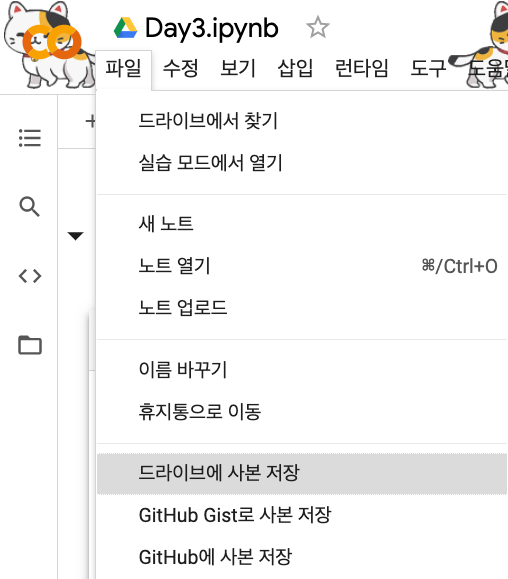

Google Colab 상단의 메뉴 중 런타임->런타임 유형 변경에서 하드웨어 가속기를 GPU 또는 TPU로 설정해주세요

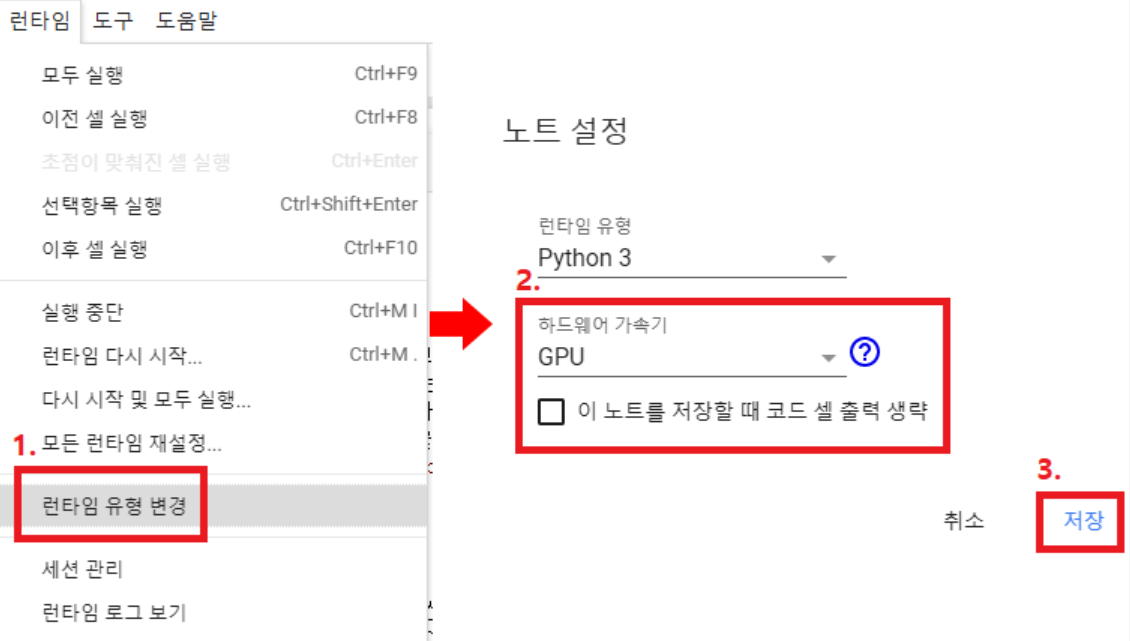

Linear layer만을 쌓은 Fully connected image classification model을 통해 PyTorch에 친숙해지며 모델이 학습 되는 과정을 체험하며 공부한 후에 직접 CNN모델을 만들어보는 시간을 갖도록 하겠습니다.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

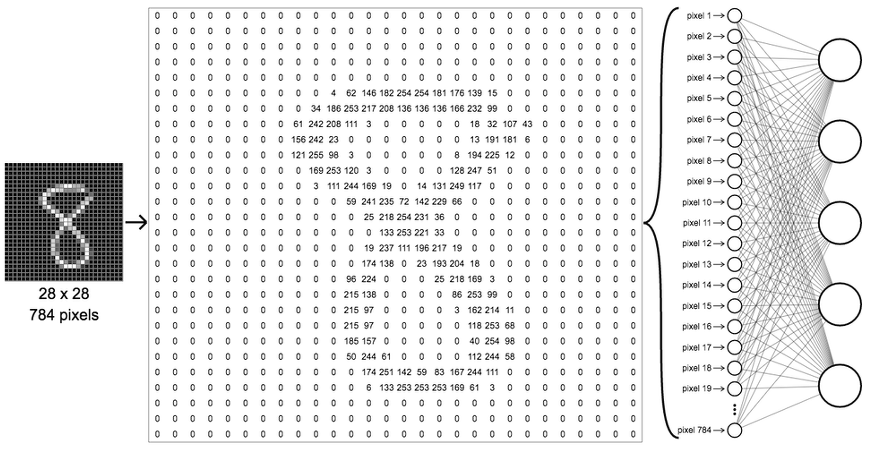

2D 입력 이미지를 위의 그림처럼 픽셀 값을 일렬로 쭉 펴준 1D 벡터 형태로 입력으로 넣어주기 때문에 input_size는 784가 됩니다.

In [2]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total

hidden_size = 500 # hidden layer의 노드 개수
num_classes = 10 #  [0,9]까지 class의 개수
num_epochs = 10 # 하단 링크 참조
batch_size = 100 # 하단 링크 참조
lr = 1e-3 # learning rate로 backpropagation시 움직이는 스텝의 크기를 결정 

참고) epoch, batch size, iteration에 관한 참고

https://losskatsu.github.io/machine-learning/epoch-batch/#2-batch-size%EC%9D%98-%EC%9D%98%EB%AF%B8


In [3]:
# MNIST data를 다운로드 받아 저장합니다. transform의 경우 다양한 종류들이 있지만 여기서는 아무것도 적용하지 않았습니다.
train_data = torchvision.datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_data = torchvision.datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 139785529.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107867937.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58038699.20it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17461529.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Data를 Loading하여 우리의 리소스 자원(GPU)에 적절한 batch size를 정하며, train dataset의 경우 dataset의 순서자체를 모델이 학습하는 것을 막기 위해 shuffle 합니다
train_gen = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_gen = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

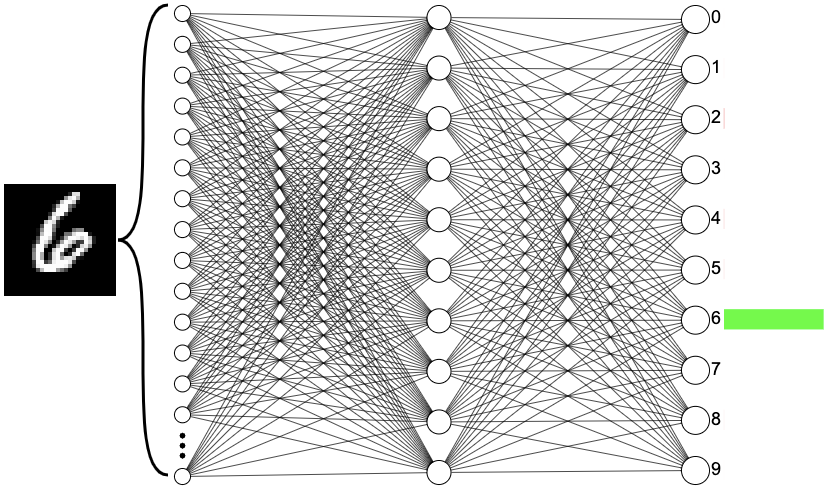

이번 시간에 고려하는 Multi-layer Perceptron (MLP)라는 model은 1개의 hidden layer를 가지며 마지막 layer는 우리가 분류하고자 하는 class의 개수(0~9까지 총 10개) 만큼의 노드를 가지게 됩니다.



In [5]:
#model class 정의
class Net(nn.Module):
  #init을 하는 부분에서 layer를 쌓을때 필요한 블럭들을 정의합니다.
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  #위에서 정의한 블럭들을 쌓아 원하는 모델을 정의하게 됩니다.
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [6]:
#Model build하기
net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

Pytorch에서는 다양한 loss function과 optimizer를 제공하는데 이 모델에 적합하다고 생각되는 loss-function과 optimizer를 하단의 자료를 읽어보고 적용해보세요. (learning rate는 위에 lr로 주어져 있습니다.)

loss function : https://nuguziii.github.io/dev/dev-002/

optimizer : https://velog.io/@reversesky/Optimizer%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%A0%95%EB%A6%AC

In [8]:
# 답안 작성

#loss-function 과 optimizer를 정해주세요! Loss function은 Pytorch의 nn 모듈 내에 있는 Loss 클레스 중 하나로 instance를 생성해주세요.
#Hint: Loss는 모델이 수행해야하는 테스크에 따라 결정됩니다. 여기서는 멀티 클레스 중 하나로 판별하는 인식 테스크를 수행 합니다.
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = lr)

학습이 되기 전의 0번째 노드와 784개의 각 픽셀값을 연결시켜주는 weight를(아래 그림에서의 빨간 부분들의 값) 시각화 시켜봅시다

무질서한 random 값들로 차있는 것을 볼 수 있습니다. 뒤에서 학습 이후의 weight는 어떻게 바뀌는지 확인하여봅시다.

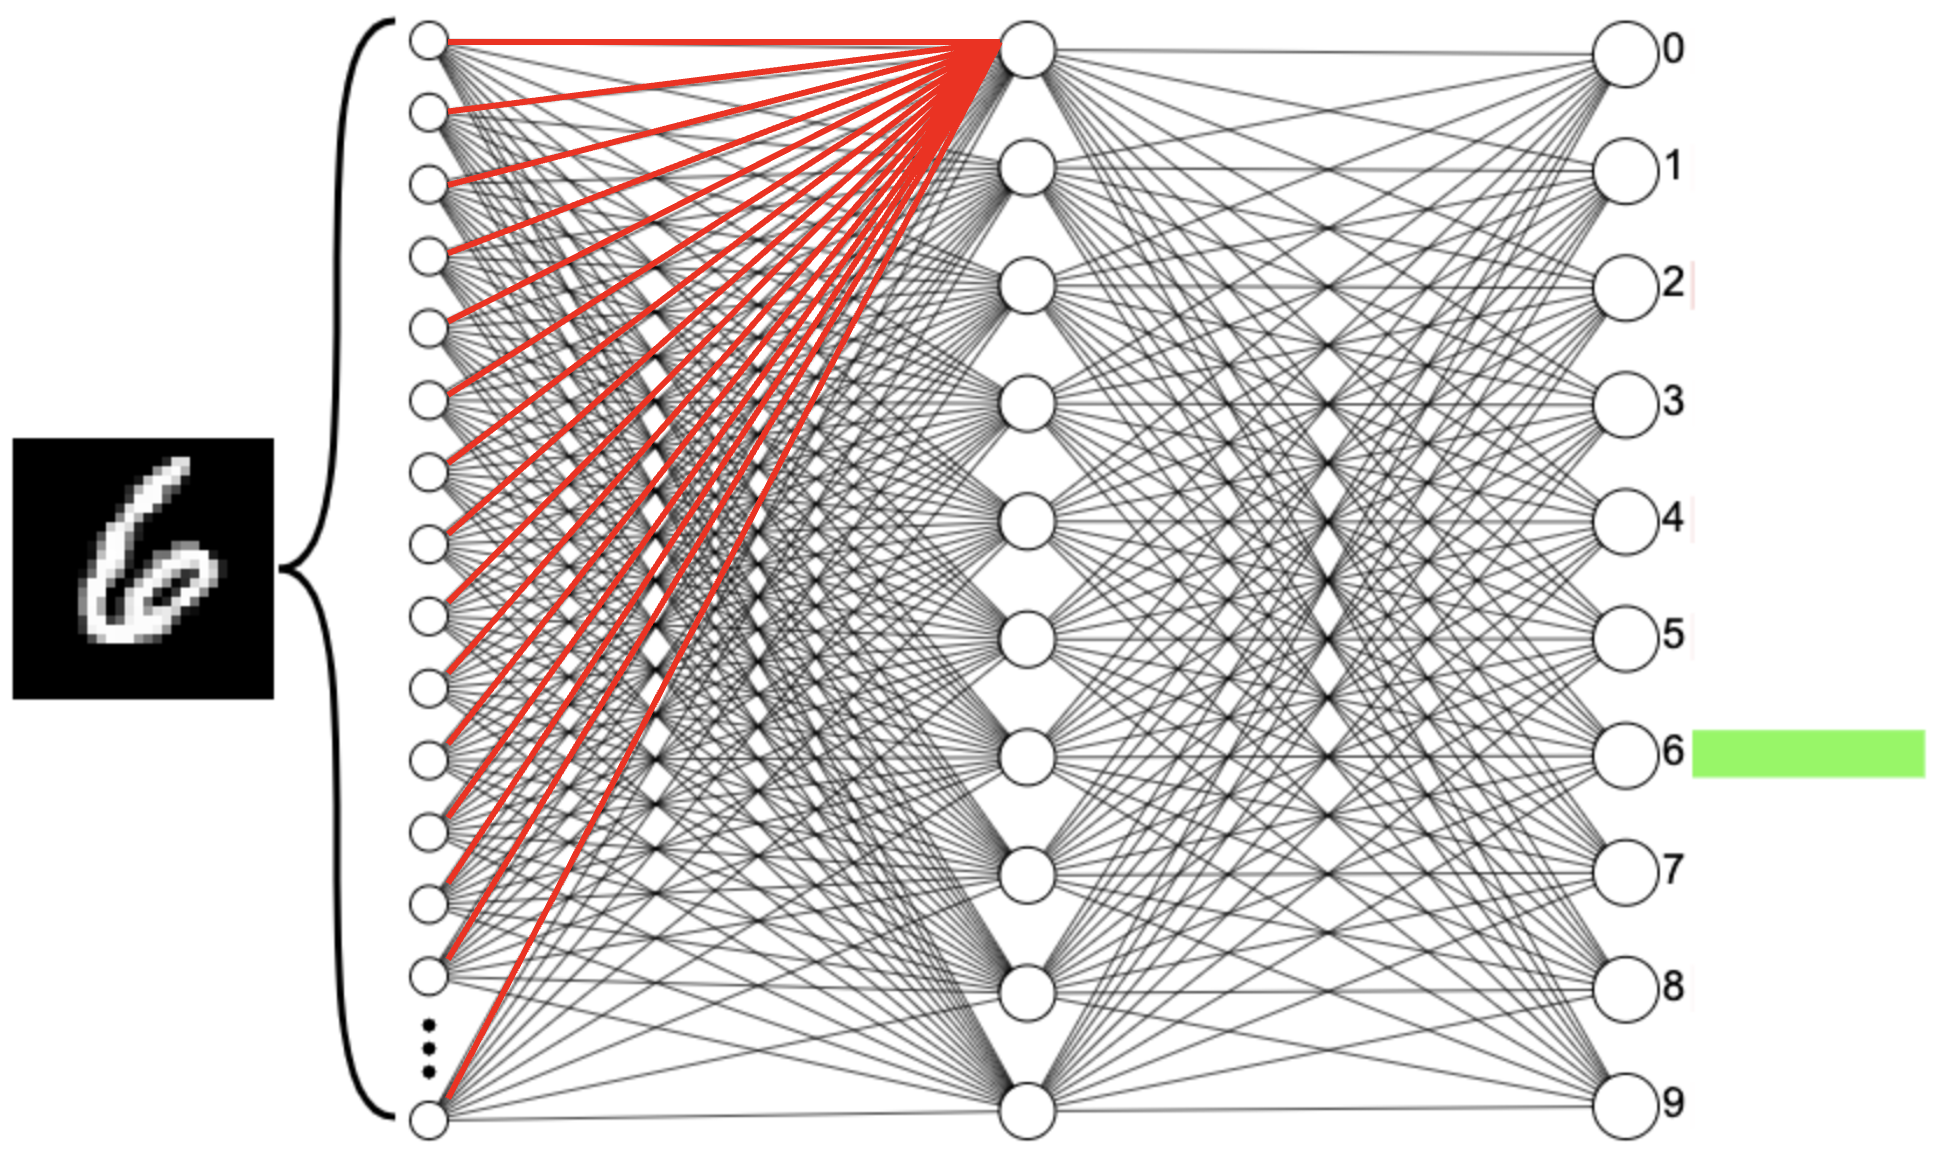

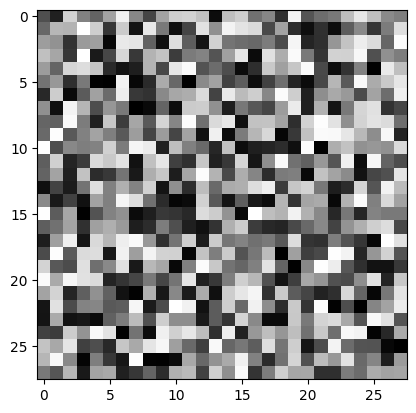

In [9]:
import matplotlib.pyplot as plt

for param_tensor in net.state_dict():
    if(param_tensor == 'fc1.weight'):
        plt.imshow(net.state_dict()[param_tensor][0].cpu().reshape(28,28), cmap='gray')

In [10]:
#Training the model
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = images.view(-1,28*28).cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data))

Epoch [1/10], Step [100/600], Loss: 0.2500
Epoch [1/10], Step [200/600], Loss: 0.2106
Epoch [1/10], Step [300/600], Loss: 0.2127
Epoch [1/10], Step [400/600], Loss: 0.1815
Epoch [1/10], Step [500/600], Loss: 0.1697
Epoch [1/10], Step [600/600], Loss: 0.1504
Epoch [2/10], Step [100/600], Loss: 0.1571
Epoch [2/10], Step [200/600], Loss: 0.0881
Epoch [2/10], Step [300/600], Loss: 0.0708
Epoch [2/10], Step [400/600], Loss: 0.1567
Epoch [2/10], Step [500/600], Loss: 0.1106
Epoch [2/10], Step [600/600], Loss: 0.1082
Epoch [3/10], Step [100/600], Loss: 0.1620
Epoch [3/10], Step [200/600], Loss: 0.0406
Epoch [3/10], Step [300/600], Loss: 0.0846
Epoch [3/10], Step [400/600], Loss: 0.1084
Epoch [3/10], Step [500/600], Loss: 0.0391
Epoch [3/10], Step [600/600], Loss: 0.0571
Epoch [4/10], Step [100/600], Loss: 0.0380
Epoch [4/10], Step [200/600], Loss: 0.0207
Epoch [4/10], Step [300/600], Loss: 0.0459
Epoch [4/10], Step [400/600], Loss: 0.0263
Epoch [4/10], Step [500/600], Loss: 0.0380
Epoch [4/10

In [11]:
#Evaluating the accuracy of the model
correct = 0
total = 0

with torch.no_grad():
  for images,labels in test_gen:
    images = images.view(-1,28*28).cuda()
    labels = labels.cuda()
    
    output = net(images)
    _, predicted = torch.max(output,1)
    correct += (predicted == labels).sum()
    total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

Accuracy of the model: 97.980 %


다음은 학습된 weight를 visualize 한 결과 입니다.

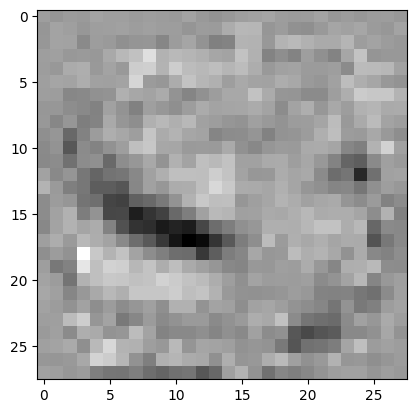

In [16]:
for param_tensor in net.state_dict():
    if(param_tensor == 'fc1.weight'):
        plt.imshow(net.state_dict()[param_tensor][283].cpu().reshape(28,28), cmap='gray')

추가적으로 몇가지 더 실험을 하여 결과를 관찰해보세요

- 현재는 0번째 노드와 784개의 각 픽셀값을 연결시켜주는 weight를 시각화 시킨 것입니다. 0~500사이의 숫자를 바꿔가며 결과를 확인해보세요!

- 다음의 링크를 읽어본 후에 실제로 학습시킨 hidden layer의 weight 결과를 확인하여보세요
https://ml4a.github.io/ml4a/ko/looking_inside_neural_nets/


**(QUIZ) 학습 전후의 weight의 값을 비교해봤을 때 fully connected layer로만 구성된 이 모델은 더 복잡한 것을 학습하는데 한계점이 있는 이유는 무엇일까요?**

참고) state_dict에 관련하여 궁금하다면 다음을 참고하세요

https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html


이번에는 28x28의 image에서 22x22만큼만 crop한 image로 dataset을 구성하면 classifier의 결과가 어떻게 변하는지 확인해봅시다.

test dataset을 구성을 할 때, 28x28의 원본 이미지에서 22x22 부분만 random crop을 한 후 28x28로 resize한 것들로 새로운 test dataset을 구성합니다.
본 실험은 Linear layer들로만 구성된 fully connected network가 영상의 일부분만 보고도 판단을 잘 하는지 확인하고, CNN의 필요성에 대해서 살펴보기 위한 중요한 예제 입니다.

torchvision.transforms와 관련된 것은 다음의 링크를 확인하세요

https://pytorch.org/vision/stable/transforms.html

transforms.Compose는 transform들을 묶어서 한번에 처리하도록 만들어줍니다.

transform과 관련된 힌트 : RandomCrop , Resize , ToTensor 



In [17]:
# 문제
# [Do it yourself] 위의 문단을 잘 읽어보고 transform_test의 내부를 구성하세요
transform_test = transforms.Compose([
    transforms.RandomCrop(22), #22*22로 자르고,
    transforms.Resize(28),  #28*28로 resize
    transforms.ToTensor()
])

test_data_crop = torchvision.datasets.MNIST(root = './data', train = False, transform = transform_test)
cropped_test_gen = torch.utils.data.DataLoader(dataset = test_data_crop, batch_size = batch_size, shuffle = False)

In [18]:
#Evaluating the accuracy of the model

correct = 0
total = 0
for images,labels in cropped_test_gen:
  images = Variable(images.view(-1,28*28)).cuda()
  labels = labels.cuda()

  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

Accuracy of the model: 41.156 %


다음 사항들을 한번 생각해봅시다.
- Accuracy가 낮아진 가장 큰 이유가 무엇인지 Fully connected layer의 한계를 기반으로 생각해보세요
- Convolution과 pooling 연산의 합성을 통해 위 한계를 극복 할 수 있다고 합니다. 어떻게 가능한걸까요?

---



### Proceed

In [19]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import torch.nn as nn
import numpy as np

## MNIST Convolutional Neural Network classifier 직접 만들어보기

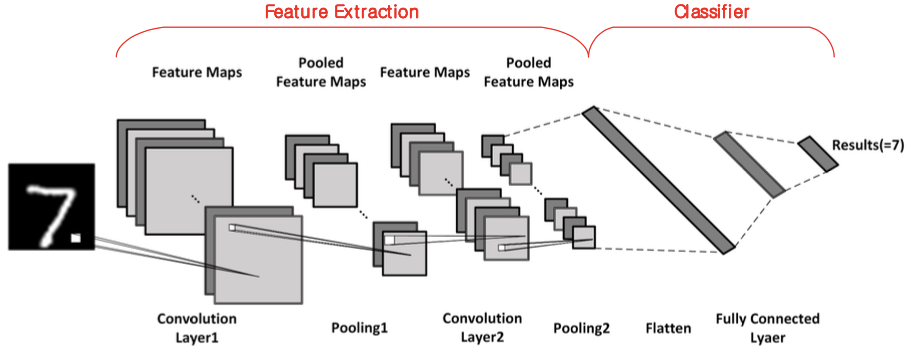

위의 그림과 같은 CNN model을 블럭들을 쌓아 만들어 봅시다.

# **Feature extraction**

Convolition Layer1 : input channel = 1, output channel = 10, kernel_size = 5

Pooling Layer1 : kernel_size = 2, stride = 1

Activation Function 1 : ReLU

Convolition Layer2 : input channel = 10, output channel = 20, kernel_size = 5

Pooling Layer2 : kernel_size = 2, stride = 1

Activation Function 2 : ReLU

# **Classifier**

Flatten : (320,1) 짜리 vector로 reshape - pytorch는 view function 이용

Fully connected layer : input = 320 , output = 50 

Activation Function : ReLU & Dropout

Fully connected layer : input = 50 , output = 10

(힌트)
CNN 모델을 구성하는 방법은 다음의 링크를 참조하세요.


https://tutorials.pytorch.kr/beginner/blitz/neural_networks_tutorial.html

In [54]:
#문제
batch_size = 128
num_epochs = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # [Do it yourelf] 모델에 필요한 레이어들 정의

        #feature extraction
        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(10,20,5)

        #classifier
        self.fc1 = nn.Linear(320,50)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        # [Do it yourelf] Forward 실행 연산 구현

        #feature extraction
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.relu(x)

        #classifier
        x = x.view(-1,320) #flatten

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
#답
batch_size = 128
num_epochs = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        ) 
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

Training을 위한 function을 만들어봅시다.

하단의 링크를 참조하시면 어떻게 구성해야 할지 감을 잡으실 수 있을 것 같습니다.

https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html 

In [55]:
#문제

# [Do it yourself] Loss function을 정의 합니다. 
criterion = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # [Do it yourself] Forward 단계: 모델에 data를 전달하여 예상되는 output 값을 계산합니다.
        output = model(data)

        # [Do it yourself] Loss를 계산 합니다.
        loss = criterion(output,target)

        # [Do it yourself] 변화도를 0으로 만들고(zero_grad), 역전파 단계를 수행하고(backward), 가중치를 갱신합니다(step).
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Model이 잘 학습이 되었는지 확인하기 위한 Test function은 다음과 같습니다. 위에서 만든 training function과 어떻게 다른지 비교해보세요!

In [56]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

train과 test에 사용할 dataset입니다.

In [57]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

model을 GPU에 올리고, 적절한 optimizer를 설정합니다.

In [58]:
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Epoch에 따라 training을 하면서 loss값은 감소하는지. test accuracy는 증가하는지 확인해봅니다.

In [59]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312213
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.277016
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.135205
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.324984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.901317

Test set: Average loss: 0.0042, Accuracy: 8509/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.720536
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.837769
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.660460
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.500696
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.445765

Test set: Average loss: 0.0021, Accuracy: 9220/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.537350
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.681356
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.338174
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.383834
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.334779

Test set: Average loss: 0.0015, Accuracy: 9398/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.356610
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [61]:
transform_test = transforms.Compose([
    transforms.RandomCrop(22),
    transforms.Resize(28),
    transforms.ToTensor()
])  

cropped_test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist_data', train=False, transform=transform_test,download=True),
    batch_size=batch_size, shuffle=True)

test(model, device, cropped_test_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 181254926.36it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 7808656.86it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64428568.47it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5865310.58it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Test set: Average loss: 0.0141, Accuracy: 5573/10000 (56%)





---



추가적으로 좀 더 복잡한 CNN모델을 만드는 방법이 궁금하다면 하단의 링크를 확인해보세요!

https://colab.research.google.com/drive/1AHhSdKd1tSnz5AZ5u8RACMiXj6E2a5B9?usp=sharing

point1 : MNIST가 아닌 다른 dataset(cifar10)으로 training, test dataset 구성

point2 : for문을 통해 더 깊은 layer를 쌓는 방법 

point3 : Colab에서 텐서보드를 통해 중간결과들을 그래프로 시각화 하는 법


수고하셨습니다.